## Machine learning for time-series electric power load forecasting

**Author**: 
Petar Sarajcev, PhD
University of Split, FESB, Department of Power Engineering, Croatia, EU.

**Ausgrid Substation Data**
Ausgrid, “Distribution zone substation information data to share,” http://www.ausgrid.com.au/Common/About-us/Corporate-information/Data-to-share/DistZone-subs.aspx#.WYD6KenauUl, accessed May, 2019.

**DarkSky API** 
Weather data from https://darksky.net/dev

In [1]:
import os
import time
import timeit
import pickle
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import cm

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import seaborn as sns
# Seaborn style (figures aesthetics)
sns.set(context='paper', style='whitegrid', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

In [5]:
%matplotlib inline

In [6]:
def restructure_input_data(filename):
    # Re-structure input data wide CSV files into long pandas dataframes
    d2 = pd.read_csv(filename)
    d2.drop(['Zone Substation', 'unit', 'year'], inplace=True, axis=1)
    d2 = d2.rename({'24:00':'23:59'}, axis='columns')  # datetime can't accept 24:00 value!
    d2['Date'] = pd.to_datetime(d2['Date'], infer_datetime_format=True)
    d2 = d2.melt(id_vars=['Date'])
    d2['variable'] = d2['variable']+':00'
    d2['variable'] = pd.to_datetime(d2['variable'], infer_datetime_format=True)
    d2['variable'] = d2['variable'].dt.time
    d2 = d2.set_index(['Date', 'variable'])
    d2 = d2.sort_index(level=[0,1]).reset_index()
    d2['DT'] = d2.apply(lambda r: pd.datetime.combine(r['Date'], r['variable']), axis=1)
    d2.set_index(d2['DT'], inplace=True)
    d2.drop(labels=['Date', 'variable', 'DT'], axis=1, inplace=True)
    d2 = d2.rename({'value':filename.split()[0]}, axis='columns')
    # Forward fill missing data 
    d2.fillna(method='ffill', axis=0, inplace=True)
    # Resample data from 15min to 1hour level
    # (weather data is available only every hour)
    d2 = d2.resample('H').mean()
    return d2

In [7]:
# Set a path to a directory with the CSV files
curr_path = os.getcwd()  # current working directory
load_dir = 'csv_files/power_load/'
os.chdir(load_dir)
files = os.listdir(os.curdir)
print('Number of substations: {:d}'.format(len(files)))
#print(files)
os.chdir(curr_path)

Number of substations: 67


In [8]:
# Read pickled geolocations
os.chdir('csv_files/')
with open('geolocations.pkl', 'rb') as file_name:
    lon_lat = pickle.load(file_name)
longitudes = lon_lat['lon']
latitudes = lon_lat['lat']
substations = lon_lat['sub']
os.chdir(curr_path)

In [9]:
# EXAMPLE: Use only locations in the vicinity of Newcastle
newcastle = (-32.928, 151.775)
newcastle_airport = (-32.81, 151.84)
location_subs = []
location_lats = []
location_lons = []
for sub, lat, lon in zip(substations, latitudes, longitudes):
    location = (lat, lon)
    dist = distance.great_circle(newcastle, location).km
    if dist < 50.:  # 50 km
        location_subs.append(sub)
        location_lats.append(lat)
        location_lons.append(lon)

In [10]:
# Process files for the Newcastle substations
print('Number of substations: {:d}'.format(len(location_subs)))
os.chdir(load_dir)
i = 0
for station in location_subs:
    print(station)
    data = restructure_input_data(station)
    if i == 0:
        df = data.copy()
    else:
        df = pd.concat([df, data], axis=1)
    i += 1
os.chdir(curr_path)
print('Done!')

Number of substations: 14
Kurri 132_11kV FY2018.csv
Broadmeadow 132_11kV FY2018.csv
Toronto_West 132_11kV FY2018.csv
Rathmines 132_11kV FY2018.csv
Mayfield_West 132_11kV FY2018.csv
Charlestown 132_11kV FY2018.csv
Maryland 132_11kV FY2018.csv
Charmhaven 132_11kV FY2018.csv
Rothbury 132_11kV FY2018.csv
Jesmond 132_11kV FY2018.csv
Lake_Munmorah 132_11kV FY2018.csv
Morisset 132_11kV FY2018.csv
Argenton 132_11kV FY2018.csv
Adamstown 132_11kV FY2018.csv
Done!


In [11]:
# Localize datetime index to "Australia/Sydney" 
df.index = df.index.tz_localize(tz='Australia/Sydney', ambiguous='NaT', nonexistent='NaT')
df.index.rename('time', inplace=True)
df.head()

,Kurri,Broadmeadow,Toronto_West,Rathmines,Mayfield_West,Charlestown,Maryland,Charmhaven,Rothbury,Jesmond,Lake_Munmorah,Morisset,Argenton,Adamstown
time,,,,,,,,,,,,,,
2017-05-01 00:00:00+10:00,9.293187,7.355490,1.532700,5.048857,9.239147,9.248663,3.754263,17.202967,2.970837,14.750807,11.071820,8.309260,11.343457,8.010340
2017-05-01 01:00:00+10:00,8.921380,7.129977,1.532700,4.396555,9.246168,8.888167,3.368525,14.855965,2.884155,14.559105,9.742450,7.252880,11.364700,8.010340
2017-05-01 02:00:00+10:00,8.517912,6.686475,1.099477,3.346163,8.156038,7.485578,2.675347,11.802657,2.920272,13.227250,8.213660,6.088737,10.424560,7.726455
2017-05-01 03:00:00+10:00,8.351537,6.535708,0.978300,2.930630,8.912705,6.721820,2.284195,10.872978,2.793130,12.026525,6.252828,5.541290,9.260480,6.579920
2017-05-01 04:00:00+10:00,8.511228,6.641385,0.978300,2.930630,8.811488,6.721820,2.287673,10.839945,2.883567,11.754460,5.640360,5.484558,8.770495,6.579920


#### DARKSKY: Read weather data from csv files and create a single dataframe

In [12]:
def process_json_weather_files(file):
    # Read json file into pandas dataframe
    weather = pd.read_json(file)
    hourly = weather['hourly'].loc['data']
    timezone = weather['timezone'].loc['data']
    dfh = pd.DataFrame(data=hourly)
    dates = pd.to_datetime(dfh['time'], unit='s')
    dates = dates.dt.tz_localize(tz='UTC', ambiguous='NaT', nonexistent='NaT')
    dates_local = dates.dt.tz_convert(tz=timezone)
    data = pd.DataFrame(data=hourly, index=dates_local)
    data = data[['cloudCover', 'dewPoint', 'humidity', 'temperature', 'windSpeed', 'icon']]
    data.fillna(method='ffill', axis=0, inplace=True)
    return data

In [13]:
curr_path = os.getcwd()  # current working directory
wdir = 'csv_files/darksky/'
os.chdir(wdir)
files = os.listdir(os.curdir)
print('Number of weather files: {:d}'.format(len(files)))
print('Processing ...')
i = 0
for file in sorted(files):
    try:
        data = process_json_weather_files(file)
    except Exception as E:
        print(file)
        print('Exception:', E)
        os.chdir(curr_path)
    if i == 0:
        dw = data.copy()
    else:
        dw = pd.concat([dw, data], axis=0)
    i += 1
os.chdir(curr_path)
print('Done!')

Number of weather files: 365
Processing ...
Done!


In [14]:
# Resample to align weather dataframe with load time-series dataframe
dw = dw.resample('H').last()
dw.head()

,cloudCover,dewPoint,humidity,temperature,windSpeed,icon
time,,,,,,
2017-05-01 00:00:00+10:00,0.00,53.15,0.94,54.93,0.26,clear-night
2017-05-01 01:00:00+10:00,0.75,54.08,0.89,57.26,0.00,partly-cloudy-night
2017-05-01 02:00:00+10:00,0.75,51.79,0.91,54.34,0.03,partly-cloudy-night
2017-05-01 03:00:00+10:00,0.44,50.43,0.93,52.52,0.00,partly-cloudy-night
2017-05-01 04:00:00+10:00,0.00,50.73,0.90,53.71,0.00,clear-night


### Concatenate weather and power load data into a single dataframe

In [15]:
dwdf = pd.concat([dw, df], join='inner', axis=1)
#dwdf = pd.concat([dw, df_cluster], join='inner', axis=1)  # using cluster analysis
dwdf.head()

,cloudCover,dewPoint,humidity,temperature,windSpeed,icon,Kurri,Broadmeadow,Toronto_West,Rathmines,Mayfield_West,Charlestown,Maryland,Charmhaven,Rothbury,Jesmond,Lake_Munmorah,Morisset,Argenton,Adamstown
time,,,,,,,,,,,,,,,,,,,,
2017-05-01 00:00:00+10:00,0.00,53.15,0.94,54.93,0.26,clear-night,9.293187,7.355490,1.532700,5.048857,9.239147,9.248663,3.754263,17.202967,2.970837,14.750807,11.071820,8.309260,11.343457,8.010340
2017-05-01 01:00:00+10:00,0.75,54.08,0.89,57.26,0.00,partly-cloudy-night,8.921380,7.129977,1.532700,4.396555,9.246168,8.888167,3.368525,14.855965,2.884155,14.559105,9.742450,7.252880,11.364700,8.010340
2017-05-01 02:00:00+10:00,0.75,51.79,0.91,54.34,0.03,partly-cloudy-night,8.517912,6.686475,1.099477,3.346163,8.156038,7.485578,2.675347,11.802657,2.920272,13.227250,8.213660,6.088737,10.424560,7.726455
2017-05-01 03:00:00+10:00,0.44,50.43,0.93,52.52,0.00,partly-cloudy-night,8.351537,6.535708,0.978300,2.930630,8.912705,6.721820,2.284195,10.872978,2.793130,12.026525,6.252828,5.541290,9.260480,6.579920
2017-05-01 04:00:00+10:00,0.00,50.73,0.90,53.71,0.00,clear-night,8.511228,6.641385,0.978300,2.930630,8.811488,6.721820,2.287673,10.839945,2.883567,11.754460,5.640360,5.484558,8.770495,6.579920


In [16]:
dwdf.values.shape

(8758, 20)

### Features engineering (time-lags)

In [17]:
# EXAMPLE Substation
station = 'Jesmond'
#station = 'Charmhaven'  # Alternative

In [18]:
main_features = True
if main_features:
    # Use only the following main weather features
    aggdata = dwdf[['temperature', 'humidity', 'dewPoint', 'windSpeed', station]].copy()
else:
    # Use extended weather features (main features + cloudCover)
    aggdata = dwdf[['temperature', 'humidity', 'dewPoint', 'windSpeed', 'cloudCover', station]].copy()
# Day ahead predictions (24h with hour measurements)
for col in aggdata.columns:
    for i in range(1,24):
        # Shift data by lag of 1 to 24 hours
        aggdata[col+'_{:d}h'.format(i)] = aggdata[col].shift(periods=i)  # time-lag
    aggdata[col+'_diff'] = aggdata[col].diff()  # difference
    aggdata[col+'_week']  =aggdata[col].shift(periods=24*7)  # previous week
# Hour-of-day indicators with cyclical transform
dayhour_ind = aggdata.index.hour
aggdata['hr_sin'] = np.sin(dayhour_ind*(2.*np.pi/24))
aggdata['hr_cos'] = np.cos(dayhour_ind*(2.*np.pi/24))
# Day-of-week indicators with cyclical transform
weekday_ind = aggdata.index.weekday
aggdata['week_sin'] = np.sin(weekday_ind*(2.*np.pi/7))
aggdata['week_cos'] = np.cos(weekday_ind*(2.*np.pi/7))
# Weekend indicator
aggdata['weekend'] = np.asarray([0 if ind <= 4 else 1 for ind in weekday_ind])
# Month indicators with cyclical transform
month_ind = aggdata.index.month
aggdata['mnth_sin'] = np.sin((month_ind-1)*(2.*np.pi/12))
aggdata['mnth_cos'] = np.cos((month_ind-1)*(2.*np.pi/12))
# one-hot-encode weather description (icon variable)
icons = pd.get_dummies(dwdf['icon'])
aggdata = aggdata.join(icons)
# Drop rows with NaN values
aggdata.dropna(inplace=True)
aggdata.head()

,temperature,humidity,dewPoint,windSpeed,Jesmond,temperature_1h,temperature_2h,temperature_3h,temperature_4h,temperature_5h,...,mnth_sin,mnth_cos,clear-day,clear-night,cloudy,fog,partly-cloudy-day,partly-cloudy-night,rain,wind
time,,,,,,,,,,,,,,,,,,,,,
2017-05-08 00:00:00+10:00,54.03,0.79,47.76,1.44,15.021013,55.68,55.31,57.45,60.94,63.67,...,0.866025,-0.5,0,0,1,0,0,0,0,0
2017-05-08 01:00:00+10:00,53.82,0.84,49.05,0.00,13.889565,54.03,55.68,55.31,57.45,60.94,...,0.866025,-0.5,0,0,1,0,0,0,0,0
2017-05-08 02:00:00+10:00,51.79,0.82,46.39,0.03,12.235263,53.82,54.03,55.68,55.31,57.45,...,0.866025,-0.5,0,0,1,0,0,0,0,0
2017-05-08 03:00:00+10:00,50.15,0.87,46.32,1.49,11.728682,51.79,53.82,54.03,55.68,55.31,...,0.866025,-0.5,0,0,0,0,0,1,0,0
2017-05-08 04:00:00+10:00,51.83,0.75,44.17,1.03,11.697333,50.15,51.79,53.82,54.03,55.68,...,0.866025,-0.5,0,0,0,0,0,1,0,0


### Forecasting load profile for a single substation

In [19]:
def dates_to_idx(timelist, start_date):
    reference_time = pd.to_datetime(start_date)
    time_delta = pd.Timedelta(1, 'h')
    timelist = timelist.dt.tz_localize(None)
    t = (timelist - reference_time) / time_delta
    return np.asarray(t)

In [20]:
# DATASETS DETERMINED USING THE WINDOW METHOD
features = [col for col in aggdata.columns if col != station]
aggdata['time'] = aggdata.index
window_days = 30  # width of the dataset window in days
# this window determines the size of the dataset that
# will be split into the training and validation sets
train_percent = 0.9  # percent of the dataset used for training
start_date = '2017-05-08'  # start date
t = dates_to_idx(aggdata['time'], start_date)
aggdata = aggdata.assign(t=t)
# Training period
st = pd.to_datetime(start_date)
et = st + dt.timedelta(days=int(train_percent*window_days)-1)
X_train = aggdata[features].loc[st:et].values
y_train = aggdata[station].loc[st:et].values
t_train = aggdata['t'].loc[st:et].values
# Validation period
sv = et #+ dt.timedelta(days=1)
ev = sv + dt.timedelta(days=int((1-train_percent)*window_days))
X_test = aggdata[features].loc[sv:ev].values  # validation
y_test = aggdata[station].loc[sv:ev].values   # validation
t_test = aggdata['t'].loc[sv:ev].values
# Testing period (one day after)
sn = ev #+ dt.timedelta(days=1)
en = sn + dt.timedelta(days=1)
X_new = aggdata[features].loc[sn:en].values
y_true = aggdata[station].loc[sn:en].values
t_new = aggdata['t'].loc[sn:en].values
print(st.date(), et.date(), sv.date(), ev.date(), sn.date(), en.date())

2017-05-08 2017-06-03 2017-06-03 2017-06-05 2017-06-05 2017-06-06


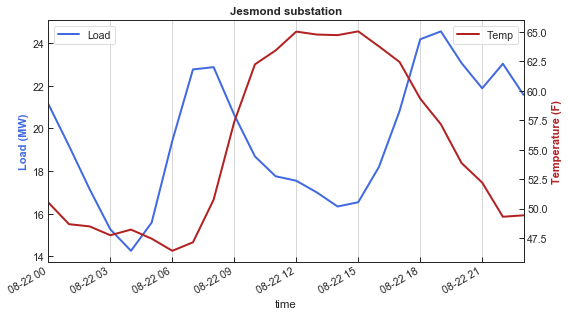

In [21]:
d = '2017-08-22'  # arbitrary day
fig, ax = plt.subplots(figsize=(8,4.5))
ax2 = ax.twinx()
ax.set_title(station+' substation', fontweight='bold')
l1 = dwdf['temperature'].loc[d].plot(ax=ax2, c='firebrick', lw=2, label='Temp')
l2 = dwdf[station].loc[d].plot(ax=ax, c='royalblue', lw=2, label='Load')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Temperature (F)', fontdict={'weight':'bold', 'color':'firebrick', 'size':11})
ax.set_ylabel('Load (MW)', fontdict={'weight':'bold', 'color':'royalblue', 'size':11})
#ax.set_xlabel('Date')
ax.grid(which='major', axis='x')
plt.tight_layout()
plt.show()

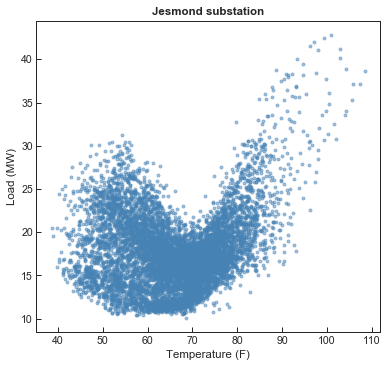

In [22]:
fig, ax = plt.subplots(figsize=(5.5,5.2))
ax.scatter(dwdf['temperature'], dwdf[station],
           s=10, c='steelblue', marker='o', alpha=0.5)
ax.set_title(station+' substation', fontweight='bold')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Load (MW)')
#ax.grid(which='major', axis='both')
fig.tight_layout()
plt.show()

## Neural Network Architectures with functional `tf.keras` API

In [23]:
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)
X_new_ = scaler.transform(X_new)

### Convolutional neural networks (LSTM or GRU layers)

In [24]:
X_train_seq = X_train_.reshape(X_train_.shape[0], 1, X_train_.shape[1])
X_train_seq.shape

(625, 1, 144)

In [25]:
X_test_seq = X_test_.reshape(X_test_.shape[0], 1, X_test_.shape[1])
X_test_seq.shape

(49, 1, 144)

#### Simple network

In [ ]:
BATCH_SIZE = 1
input_layer = keras.layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]), batch_size=BATCH_SIZE)
x = keras.layers.LSTM(64, activation='elu', dropout=0.1, recurrent_dropout=0.1, stateful=True)(input_layer)
output_layer = keras.layers.Dense(1)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mae', optimizer='adam', metrics=['mape'])

#### Deep network (stacking layers)

In [26]:
BATCH_SIZE = 1
input_layer = keras.layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]), batch_size=BATCH_SIZE)
x = keras.layers.GRU(32, activation='elu', dropout=0.1, recurrent_dropout=0.1, 
                     stateful=True, return_sequences=True)(input_layer)
x = keras.layers.GRU(64, activation='elu', dropout=0.1, recurrent_dropout=0.1, stateful=True)(x)
output_layer = keras.layers.Dense(1)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mae', optimizer='adam', metrics=['mape'])

In [27]:
# Training with "reset_state" between epochs
EPOCHS = 50
loss = []; val_loss = []
for i in range(EPOCHS):
    print('EPOCH: {:d}/{:d}'.format(i+1, EPOCHS))
    history = model.fit(X_train_seq, y_train, BATCH_SIZE, epochs=1,
                        validation_data=[X_test_seq, y_test], shuffle=False, verbose=1)
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    model.reset_states()

EPOCH: 1/50
Train on 625 samples, validate on 49 samples
625/625 [==============================] - 9s 14ms/sample - loss: 4.8651 - mape: 28.1581 - val_loss: 4.5046 - val_mape: 24.6144
EPOCH: 2/50
Train on 625 samples, validate on 49 samples
625/625 [==============================] - 5s 8ms/sample - loss: 2.3235 - mape: 13.5793 - val_loss: 1.9896 - val_mape: 10.0543
EPOCH: 3/50
Train on 625 samples, validate on 49 samples
625/625 [==============================] - 5s 9ms/sample - loss: 1.8720 - mape: 10.7561 - val_loss: 3.3716 - val_mape: 17.3282
EPOCH: 4/50
Train on 625 samples, validate on 49 samples
625/625 [==============================] - 5s 9ms/sample - loss: 1.8628 - mape: 10.6009 - val_loss: 2.6927 - val_mape: 13.8628
EPOCH: 5/50
Train on 625 samples, validate on 49 samples
625/625 [==============================] - 6s 10ms/sample - loss: 2.2418 - mape: 12.9141 - val_loss: 1.8584 - val_mape: 9.8573
EPOCH: 6/50
Train on 625 samples, validate on 49 samples
625/625 [=============

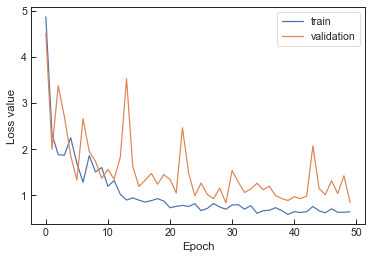

In [28]:
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# DO NOT EXECUTE!
# Alternative training without "reset_state"
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, 
                                           restore_best_weights=True, verbose=1)
history = model.fit(X_train_seq, y_train, BATCH_SIZE, epochs=50, callbacks=[early_stop],
                    validation_data=[X_test_seq, y_test], shuffle=False, verbose=1)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [29]:
# Forecasting one time step ahead
def forecast(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [30]:
y_pred = np.empty_like(y_true)
for i in range(len(X_new_)):
	X = X_new_[i,:]
	yhat = forecast(model, 1, X)
	y_pred[i] = yhat

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)/y_true))*100.

In [32]:
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE = {:.2f} (%)'.format(mape))

MAPE = 5.84 (%)


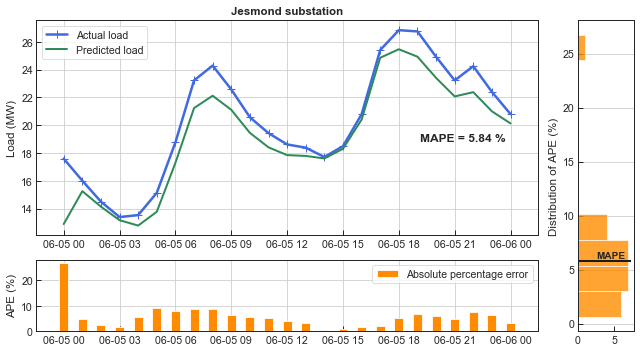

In [33]:
fig = plt.figure(figsize=(9,5))
gx = gs.GridSpec(nrows=2, ncols=2, figure=fig, height_ratios=[3,1], width_ratios=[9,1])
ax = np.empty(shape=(2,1), dtype=np.ndarray)
ax[0,0] = fig.add_subplot(gx[0,0])
ax[1,0] = fig.add_subplot(gx[1,0], sharex=ax[0,0])
axr = fig.add_subplot(gx[:,1])
ax[0,0].set_title(station+' substation', fontweight='bold')
ax[0,0].plot(dwdf.loc[sn:en].index, y_true, 
             lw=2.5, color='royalblue', marker='+', markersize=8, label='Actual load')
ax[0,0].plot(dwdf.loc[sn:en].index, y_pred, 
             lw=2, color='seagreen', label='Predicted load')
ax[0,0].text(0.85, 0.45, 'MAPE = {:.2f} %'.format(mape), 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=12, fontweight='bold',
             transform=ax[0,0].transAxes)  # relative coordinates
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Load (MW)')
ax[0,0].grid(True)
# Absolute percentage error
abs_perc_error = np.abs((y_true - y_pred) / y_true)*100.
ax[1,0].bar(dwdf.loc[sn:en].index, abs_perc_error, width=0.02, 
            color='darkorange', label='Absolute percentage error')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('APE (%)')
ax[1,0].grid(True)
# Histogram of error distribution
axr.hist(abs_perc_error, bins='auto', orientation='horizontal', 
         color='darkorange', alpha=0.8)
xlims = axr.get_xlim()
axr.hlines(mape, 0, xlims[1], colors='k', lw=2)
axr.text(2.5, mape+0.2, 'MAPE', fontweight='bold')
axr.grid(axis='y')
axr.set_ylabel('Distribution of APE (%)')
fig.tight_layout()
#plt.savefig('{}_gru.png'.format(station), dpi=800)
plt.show()

### Deep feed-forward neural network

In [34]:
BATCH_SIZE = 512
input_layer = keras.layers.Input(shape=X_train_.shape[1:])
x = keras.layers.Dense(units=256, activation='relu')(input_layer)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(units=256, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(1)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mae', optimizer='adam', metrics=['mape'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, 
                                           patience=20, verbose=1)
history = model.fit(X_train_, y_train, BATCH_SIZE, epochs=200, 
                    validation_data=(X_test_, y_test),
                    callbacks=[early_stop], shuffle=False, verbose=1)

Train on 625 samples, validate on 49 samples
Epoch 1/200
625/625 [==============================] - 1s 1ms/sample - loss: 18.3084 - mape: 103.0292 - val_loss: 16.7864 - val_mape: 92.5012
Epoch 2/200
625/625 [==============================] - 0s 197us/sample - loss: 16.2492 - mape: 91.1008 - val_loss: 14.9355 - val_mape: 81.8459
Epoch 3/200
625/625 [==============================] - 0s 164us/sample - loss: 14.3567 - mape: 80.2511 - val_loss: 13.0074 - val_mape: 70.7280
Epoch 4/200
625/625 [==============================] - 0s 149us/sample - loss: 12.4137 - mape: 69.1508 - val_loss: 10.9364 - val_mape: 58.7597
Epoch 5/200
625/625 [==============================] - 0s 166us/sample - loss: 10.3114 - mape: 57.2677 - val_loss: 8.6439 - val_mape: 45.4994
Epoch 6/200
625/625 [==============================] - 0s 166us/sample - loss: 8.2082 - mape: 45.5208 - val_loss: 6.6655 - val_mape: 34.7050
Epoch 7/200
625/625 [==============================] - 0s 190us/sample - loss: 6.7255 - mape: 37.0819

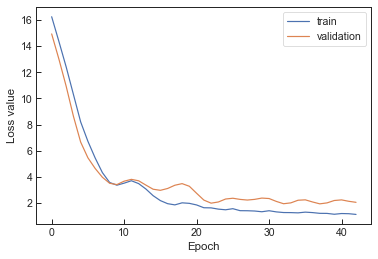

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss[1:], label='train')
plt.plot(val_loss[1:], label='validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [36]:
y_pred = model.predict(X_new_)
y_pred = y_pred.flatten()

In [37]:
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE = {:.2f} (%)'.format(mape))

MAPE = 6.07 (%)


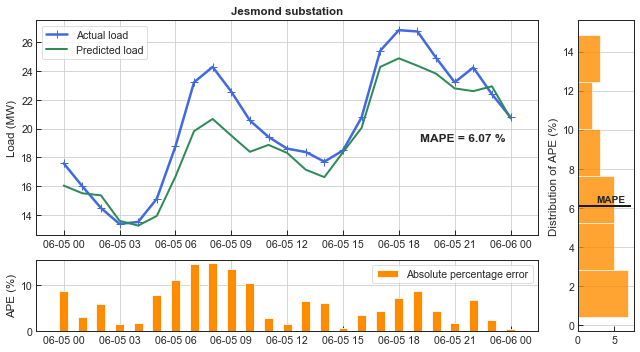

In [38]:
fig = plt.figure(figsize=(9,5))
gx = gs.GridSpec(nrows=2, ncols=2, figure=fig, height_ratios=[3,1], width_ratios=[9,1])
ax = np.empty(shape=(2,1), dtype=np.ndarray)
ax[0,0] = fig.add_subplot(gx[0,0])
ax[1,0] = fig.add_subplot(gx[1,0], sharex=ax[0,0])
axr = fig.add_subplot(gx[:,1])
ax[0,0].set_title(station+' substation', fontweight='bold')
ax[0,0].plot(dwdf.loc[sn:en].index, y_true, 
             lw=2.5, color='royalblue', marker='+', markersize=8, label='Actual load')
ax[0,0].plot(dwdf.loc[sn:en].index, y_pred, 
             lw=2, color='seagreen', label='Predicted load')
ax[0,0].text(0.85, 0.45, 'MAPE = {:.2f} %'.format(mape), 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=12, fontweight='bold',
             transform=ax[0,0].transAxes)  # relative coordinates
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Load (MW)')
ax[0,0].grid(True)
# Absolute percentage error
abs_perc_error = np.abs((y_true - y_pred) / y_true)*100.
ax[1,0].bar(dwdf.loc[sn:en].index, abs_perc_error, width=0.02, 
            color='darkorange', label='Absolute percentage error')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('APE (%)')
ax[1,0].grid(True)
# Histogram of error distribution
axr.hist(abs_perc_error, bins='auto', orientation='horizontal', 
         color='darkorange', alpha=0.8)
xlims = axr.get_xlim()
axr.hlines(mape, 0, xlims[1], colors='k', lw=2)
axr.text(2.5, mape+0.2, 'MAPE', fontweight='bold')
axr.grid(axis='y')
axr.set_ylabel('Distribution of APE (%)')
fig.tight_layout()
#plt.savefig('{}_dnn.png'.format(station), dpi=800)
plt.show()

#### Feature selection using importance analysis

In [39]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [40]:
parameters = {'n_estimators':[500, 1000],
              'max_depth':[1, 3, None]}
rfr = GridSearchCV(estimator=RandomForestRegressor(criterion='mse'), 
                   param_grid=parameters, cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_squared_error', 
                   refit=True, n_jobs=-1, iid=False)
rfr.fit(X_train, y_train);

In [41]:
rfr.best_params_

{'max_depth': None, 'n_estimators': 500}

In [42]:
forest = RandomForestRegressor(criterion='mse', **rfr.best_params_)
forest.fit(X_train, y_train)
selector = SelectFromModel(estimator=forest, threshold='median', prefit=True)
X_train_select = selector.transform(X_train)
X_test_select = selector.transform(X_test)
X_new_select = selector.transform(X_new)

In [43]:
X_train.shape

(625, 144)

In [44]:
X_train_select.shape

(625, 72)

### Wide and Deep neural network

In [45]:
# Scaling selected features
scaler_select = StandardScaler()
X_train_sc = scaler_select.fit_transform(X_train_select)
X_test_sc = scaler_select.transform(X_test_select)
X_new_sc = scaler_select.transform(X_new_select)

In [46]:
X_train_sc.shape[1:]

(72,)

In [52]:
BATCH_SIZE = 512
# Deep Network with two parallel branches
# This branch uses all features
input_layer_all = keras.layers.Input(shape=X_train_.shape[1:])
h1a = keras.layers.Dense(units=256, activation='relu')(input_layer_all)
h2a = keras.layers.Dropout(0.1)(h1a)
h3a = keras.layers.Dense(units=256, activation='relu')(h2a)
h4a = keras.layers.Dropout(0.1)(h3a)
# THis branch uses only select features (from importance analysis)
input_layer_sel = keras.layers.Input(shape=X_train_sc.shape[1:])
h1 = keras.layers.Dense(128, activation='relu')(input_layer_sel)
h2 = keras.layers.Dropout(0.1)(h1)
h3 = keras.layers.Dense(128, activation='relu')(h2)
h4 = keras.layers.Dropout(0.1)(h3)
# Wide and Deep model (concatenate branches with best input features)
concat1 = keras.layers.Concatenate()([h4a, h4])
hx = keras.layers.Dense(64, activation='relu')(concat1)
concat2 = keras.layers.Concatenate()([input_layer_sel, hx])
output = keras.layers.Dense(64, activation='relu')(concat2)
output_layer = keras.layers.Dense(1)(output)
model = keras.models.Model(inputs=[input_layer_all, input_layer_sel], 
                           outputs=[output_layer])
model.compile(loss='mae', optimizer='adam', metrics=['mape'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, 
                                           patience=20, restore_best_weights=True,
                                           verbose=1)
history = model.fit([X_train_, X_train_sc], y_train, BATCH_SIZE, epochs=200, 
                    validation_data=([X_test_, X_test_sc], y_test),
                    callbacks=[early_stop], shuffle=False, verbose=1)

Train on 625 samples, validate on 49 samples
Epoch 1/200
625/625 [==============================] - 1s 2ms/sample - loss: 18.7079 - mape: 104.9346 - val_loss: 18.1849 - val_mape: 100.2174
Epoch 2/200
625/625 [==============================] - 0s 153us/sample - loss: 17.5384 - mape: 98.2712 - val_loss: 17.4184 - val_mape: 95.8560
Epoch 3/200
625/625 [==============================] - 0s 210us/sample - loss: 16.5512 - mape: 92.7132 - val_loss: 16.4386 - val_mape: 90.2446
Epoch 4/200
625/625 [==============================] - 0s 206us/sample - loss: 15.2738 - mape: 85.5290 - val_loss: 15.0388 - val_mape: 82.2193
Epoch 5/200
625/625 [==============================] - 0s 301us/sample - loss: 13.5433 - mape: 75.7898 - val_loss: 13.0927 - val_mape: 71.0528
Epoch 6/200
625/625 [==============================] - 0s 224us/sample - loss: 11.1781 - mape: 62.4758 - val_loss: 10.4764 - val_mape: 56.0196
Epoch 7/200
625/625 [==============================] - 0s 160us/sample - loss: 8.2180 - mape: 46.

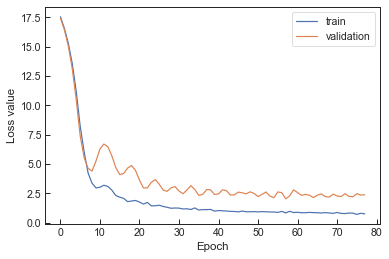

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss[1:], label='train')
plt.plot(val_loss[1:], label='validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [54]:
y_pred = model.predict([X_new_, X_new_sc])
y_pred = y_pred.flatten()

In [55]:
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE = {:.2f} (%)'.format(mape))

MAPE = 4.18 (%)


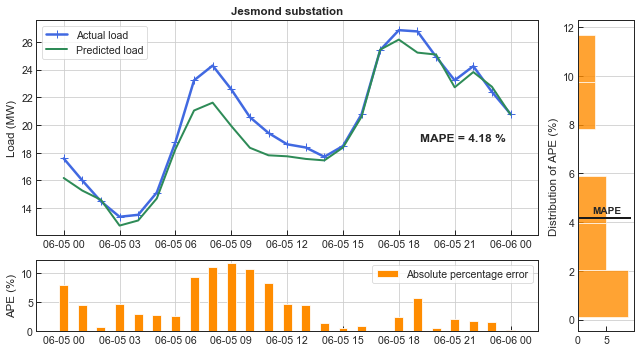

In [56]:
fig = plt.figure(figsize=(9,5))
gx = gs.GridSpec(nrows=2, ncols=2, figure=fig, height_ratios=[3,1], width_ratios=[9,1])
ax = np.empty(shape=(2,1), dtype=np.ndarray)
ax[0,0] = fig.add_subplot(gx[0,0])
ax[1,0] = fig.add_subplot(gx[1,0], sharex=ax[0,0])
axr = fig.add_subplot(gx[:,1])
ax[0,0].set_title(station+' substation', fontweight='bold')
ax[0,0].plot(dwdf.loc[sn:en].index, y_true, 
             lw=2.5, color='royalblue', marker='+', markersize=8, label='Actual load')
ax[0,0].plot(dwdf.loc[sn:en].index, y_pred, 
             lw=2, color='seagreen', label='Predicted load')
ax[0,0].text(0.85, 0.45, 'MAPE = {:.2f} %'.format(mape), 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=12, fontweight='bold',
             transform=ax[0,0].transAxes)  # relative coordinates
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Load (MW)')
ax[0,0].grid(True)
# Absolute percentage error
abs_perc_error = np.abs((y_true - y_pred) / y_true)*100.
ax[1,0].bar(dwdf.loc[sn:en].index, abs_perc_error, width=0.02, 
            color='darkorange', label='Absolute percentage error')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('APE (%)')
#ax[1,0].set_xlabel('Date')
ax[1,0].grid(True)
# Histogram of error distribution
axr.hist(abs_perc_error, bins='auto', orientation='horizontal', 
         color='darkorange', alpha=0.8)
xlims = axr.get_xlim()
axr.hlines(mape, 0, xlims[1], colors='k', lw=2)
axr.text(2.5, mape+0.2, 'MAPE', fontweight='bold')
axr.grid(axis='y')
axr.set_ylabel('Distribution of APE (%)')
fig.tight_layout()
#fig.savefig('{}_wide_deep.png'.format(station), dpi=800)
plt.show()